# Development: Training Sample Generator
Notebook for prototyping and testing the training sample generator used to create training samples on the fly from pre-existing chips. The generator is intended for use with the Keras training function `fit_generator` __[described here](https://keras.io/models/sequential/#fit_generator)__. After successful testing, code will be migrated to the codebase proper, while this notebook will be preserved for future extensions of functionality. This notebook is based largely on Brookie's "toy generator" __[available here](https://gist.github.com/brookisme/9dbddb0046d0ee4096ed86037135c818)__. Edit: so far it's basically a copy with trivial modifications.  

Author: Peter Kerins  
Date: 28 January 2019  

In [1]:
import os, sys
import pandas as pd
import numpy as np
import math
import rasterio as rio
import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import to_categorical

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
import util_rasters

Using TensorFlow backend.


In [2]:
# helpers
DEFAULT_BATCH_SIZE=64
DEFAULT_LOOK_WINDOW=17

def image_data(path):
    with rio.open(path,'r') as src:
        profile=src.profile
        image=src.read()
    return image, profile

# def image_data(path):
#     return np.random.rand(8,17,17), {'fake_data':True,'path':path}

def bands_last(img):
    return img.swapaxes(0,1).swapaxes(1,2)

In [3]:
# class itself
class SampleGenerator(object):
    
    # constructor
    def __init__(self,
                df,
                batch_size=64,
                look_window=17,
                remapping=None,
                one_hot=True,
                ):
        self.batch_size=batch_size
        self.look_window=look_window
        
        if remapping is None:
            self.remapping = remapping
        else:
            if isinstance(remapping, dict):
                self.remapping = remapping
            elif isinstance(remapping, str):
                if remapping.lower() == '3cat' or remapping.lower() == '3category':
                    self.remapping = {0:0,1:1,2:2,3:2,4:2,5:2,6:3}
                elif remapping.lower() == 'roads':
                    self.remapping = {0:0,1:0,2:0,3:0,4:0,5:0,6:1}
                else:
                    raise ValueError('Unrecognized remapping identifier: ',remapping)
            else:
                raise ValueError('Illegal object passed as remapping: ',remapping)
        self.one_hot = one_hot
        self._set_data(df)
        
    def _set_data(self,
                  df):
        """ set data
            * read csv
            * set input/target_paths
            * reset(shuffle,etc...)
        """
        if isinstance(df,str):
            self.dataframe=pd.read_csv(data)
        else:
            self.dataframe=df
        self.size=self.dataframe.shape[0]
        self.steps=int(math.floor(1.0*self.size/self.batch_size))
        self.reset()

    def reset(self):
        """ reset the generator
            * reset batch index to -1
            * shuffle input/target paths
        """
        self.profiles=None
        self.rows=None
        self.batch_index=-1
        # randomization step (?)
        self.dataframe=self.dataframe.sample(frac=1)
        
    # iteration
    def __next__(self):
        """ batchwise return tuple of (inputs,targets)
        """        
        start,end=self._batch_range()
        self.rows=self.dataframe.iloc[start:end]
        inputs,self.profiles=self._get_inputs()
        targets=self._get_targets()
        return inputs, targets
        
    def _batch_range(self):
        """ batch setup
            * reset if batch_index >= # of steps
            * increment batch_index
            * start/end indices for batch_index
        """
        if (self.batch_index+1>=self.steps):
            self.reset()
        self.batch_index+=1
        start=self.batch_index*self.batch_size
        end=start+self.batch_size
        return start,end

    def _get_inputs(self):
        imgs=[]
        profiles=[]
        for path in self.rows.path:
            im,profile=self._read_image(path)
            im2 = self._construct_sample(im, self.look_window/2)
            imgs.append(im2)
            profiles.append(profile)
        return np.array(imgs),profiles    
    
    # simple example of more customized input generator
    def _construct_sample(self, im, look_radius):
        assert im.shape[0] == im.shape[1]
        im_side = im.shape[0]
        center = im_side/2
        return util_rasters.window(im,center,center,look_radius,bands_first=False)
    
    def _read_image(self,path):
        with rio.open(path,'r') as src:
            profile=src.profile
            image=src.read()
        #bands last
        im = image.swapaxes(0,1).swapaxes(1,2)
        return im,profile

    def _get_targets(self):
        categories = list(self.rows.lulc)
        targets = np.array(categories)
        if self.remapping is not None:
            for k in sorted(self.remapping.iterkeys()):
                targets[targets==k] = self.remapping[k]
        if self.one_hot:
            targets = to_categorical(targets)
        return targets

    # other
    def __iter__(self):
        """py2: define as iterator"""
        return self
    
    def next(self):
        """py2: alias __next__"""
        return self.__next__()        

In [5]:
path_catalog = '/data/phase_iv/sitapur/chips/none/chip_catalog.csv'
df = pd.read_csv(path_catalog)
print len(df)
df

172551


,path,city,gt_type,gt_lot,locale,source,image,bands,resolution,resampling,processing,tile_id,x,y,lulc
0,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,255,171,0
1,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,253,172,0
2,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,254,172,0
3,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,255,172,0
4,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,251,173,1
5,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,252,173,0
6,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,253,173,0
7,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,254,173,0
8,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,255,173,0
9,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,250,174,1


In [6]:
mask = df['lulc']!=6
df = df[mask]
df

,path,city,gt_type,gt_lot,locale,source,image,bands,resolution,resampling,processing,tile_id,x,y,lulc
0,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,255,171,0
1,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,253,172,0
2,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,254,172,0
3,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,255,172,0
4,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,251,173,1
5,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,252,173,0
6,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,253,173,0
7,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,254,173,0
8,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,255,173,0
9,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,NaN,176,250,174,1


In [7]:
tg=SampleGenerator(df)

In [8]:
input_batch,target_batch=next(tg)
input_batch.shape,target_batch.shape

((64, 17, 17, 7), (64, 4))

In [9]:
print target_batch[0]

[0. 0. 0. 1.]


In [10]:
im =input_batch[0]

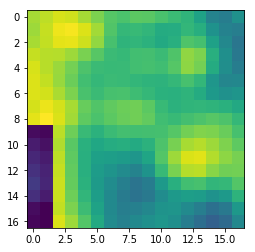

In [11]:
plt.imshow(im[:,:,0].astype('uint8'))

In [12]:
tg.profiles[0]

{'affine': Affine(5.0, 0.0, 467810.0,
       0.0, -5.0, 3049855.0),
 'count': 7,
 'crs': CRS({'init': u'epsg:32644'}),
 'driver': u'GTiff',
 'dtype': 'uint16',
 'height': 65,
 'interleave': 'pixel',
 'nodata': None,
 'tiled': False,
 'transform': (467810.0, 5.0, 0.0, 3049855.0, 0.0, -5.0),
 'width': 65}